In [1]:
! pip install ipynb

In [2]:
! pip install --upgrade scikit-learn

Requirement already up-to-date: scikit-learn in c:\users\njula chakaya\anaconda3\lib\site-packages (1.0.2)


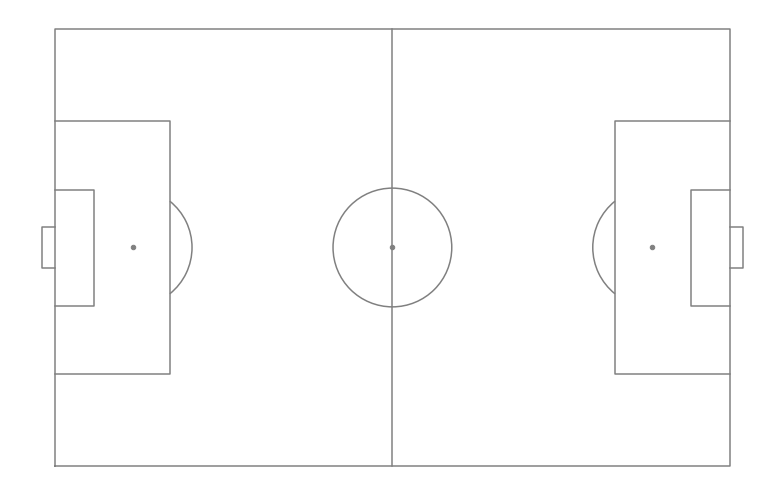

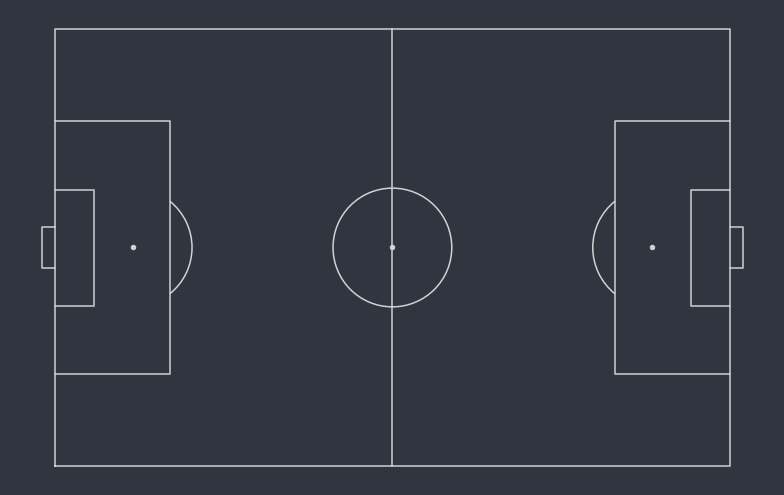

In [3]:
import os
import json

import seaborn as sns 
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.patches import Arc

from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE

from ipynb.fs.full.FBPitch import draw_pitch

In [4]:
# Importing the jsonfiles
directory = (r'C:\Users\Njula Chakaya\Downloads\events')
jsonfiles = []

for path in os.listdir(directory):
    jsonfiles.append(os.path.join(directory,path))

print(jsonfiles)

['C:\\Users\\Njula Chakaya\\Downloads\\events\\events_England.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_European_Championship.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_France.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_Germany.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_Italy.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_Spain.json', 'C:\\Users\\Njula Chakaya\\Downloads\\events\\events_World_Cup.json']


In [5]:
# Data extraction of relevant data
def shot_matrix(events):
    with open(events) as f:
        data = json.load(f)
    
    # New DataFrame to store the extracted data with the relevant variables
    shots_data =  pd.DataFrame(columns=['Goal','x','y','playerid','teamid','matchid','header','Right Foot','Left Foot'])
    
    event_data = pd.DataFrame(data)
    #Getting data on shots only
    all_shots = event_data[event_data['subEventName']== 'Shot']
    
    for index, shot in all_shots.iterrows():
        
        #Fill in the goals and header columns
        shots_data.at[index, 'Goal'] = 0 # not a goal
        shots_data.at[index, 'header'] = 0 # not a header
        shots_data.at[index, 'Right Foot'] = 0 # not right foot goal
        shots_data.at[index, 'Left Foot'] = 0 # not left foot goal
        
        for tag in shot['tags']:
            if tag ['id'] == 101: # tag for goal in dataset description by Wyscout
                shots_data.at[index, 'Goal'] = 1 # a goal
            elif tag ['id'] == 403: # tag for header
                shots_data.at[index, 'header'] =1 # a header
            elif tag ['id'] == 401: # tag for left foot
                shots_data.at[index, 'Left Foot'] = 1
            elif tag ['id'] == 402: # tag for right foot
                shots_data.at[index, 'Right Foot'] = 1
        
        # Fill in column for distance and angle , X and Y coordinates represents nearness to the top left corner of pitch of 105 by 68
        shots_data.at[index, 'Y'] = shot['positions'][0]['y']* .68 # mapping Y coordinates 
        shots_data.at[index, 'X'] = (100-shot['positions'][0]['x'])* 1.05 # mapping X coordinates
        
        # Dummy variables x and y to calculate distance
        shots_data.at[index, 'x'] = 100 - shot['positions'][0]['x']
        shots_data.at[index, 'y'] = shot['positions'][0]['y']
        shots_data.at[index, 'Center_dis'] = abs(shot['positions'][0]['y'] - 50)
        
        x = shots_data.at[index, 'x']* 1.05
        y = shots_data.at[index, 'Center_dis'] * .68
        shots_data.at[index, 'Distance'] = np.sqrt(x**2 + y**2)
        
        # Fill in the angle made btwn the width of the goal and straight line distance to the shot location
        # law of cosines is used
        c = 7.32 # width of a goal post
        a = np.sqrt((y - 7.32/2)**2 + x**2)
        b = np.sqrt((y + 7.32/2)**2 + x**2)
        k = (c**2 - a**2 - b**2)/(-2 * a * b)
        gamma = np.arccos(k)
        if gamma < 0:
            gamma = np.pi + gamma
        shots_data.at[index, 'Angle Radians'] = gamma
        shots_data.at[index, 'Angle Degrees'] = gamma * 180/np.pi
        
        shots_data.at[index, 'playerid'] = shot['playerId']
        shots_data.at[index, 'matchid'] = shot['matchId']
        shots_data.at[index, 'teamid'] = shot['teamId']
        
    return shots_data

In [6]:
all_leagues = []

for file in jsonfiles:
    all_leagues.append(shot_matrix(file))
    
data_1 = pd.concat(all_leagues)

C:\Users\Njula Chakaya\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in arccos


In [7]:
data_1.sample(10)

,Goal,x,y,playerid,teamid,matchid,header,Right Foot,Left Foot,Y,X,Center_dis,Distance,Angle Radians,Angle Degrees
623469,0,11,73,3325,677,2565924,0,1,0,49.64,11.55,23.0,19.442533,0.227850,13.054837
504603,0,24,60,65207,2482,2517035,0,1,0,40.80,25.20,10.0,26.101341,0.269474,15.439700
42387,0,13,37,25795,680,2565575,0,0,1,25.16,13.65,13.0,16.262475,0.378751,21.700811
368593,0,30,70,11063,3157,2576176,0,0,1,47.60,31.50,20.0,34.310494,0.195591,11.206563
492816,0,20,63,20879,3158,2576247,0,1,0,42.84,21.00,13.0,22.784767,0.295072,16.906368
256867,0,21,51,14798,2447,2516892,0,0,1,34.68,22.05,1.0,22.060483,0.328675,18.831672
519263,1,7,50,269152,3176,2576263,0,1,0,34.00,7.35,0.0,7.350000,0.924027,52.942861
38864,0,13,36,25716,3777,2500709,0,1,0,24.48,13.65,14.0,16.641902,0.362372,20.762369
146550,0,15,52,8717,1624,2499807,0,0,1,35.36,15.75,2.0,15.808608,0.453557,25.986925
67402,0,16,46,70965,9905,1694434,0,1,0,31.28,16.80,4.0,17.018766,0.418833,23.997366


In [8]:
data_1.shape

(43078, 15)

In [9]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43078 entries, 46 to 101653
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Goal           43078 non-null  object 
 1   x              43078 non-null  object 
 2   y              43078 non-null  object 
 3   playerid       43078 non-null  object 
 4   teamid         43078 non-null  object 
 5   matchid        43078 non-null  object 
 6   header         43078 non-null  object 
 7   Right Foot     43078 non-null  object 
 8   Left Foot      43078 non-null  object 
 9   Y              43078 non-null  float64
 10  X              43078 non-null  float64
 11  Center_dis     43078 non-null  float64
 12  Distance       43078 non-null  float64
 13  Angle Radians  43075 non-null  float64
 14  Angle Degrees  43075 non-null  float64
dtypes: float64(6), object(9)
memory usage: 5.3+ MB


In [10]:
# Check for null values
data_1.isnull().values.any()

True

In [11]:
data_1.isnull().sum()

Goal             0
x                0
y                0
playerid         0
teamid           0
matchid          0
header           0
Right Foot       0
Left Foot        0
Y                0
X                0
Center_dis       0
Distance         0
Angle Radians    3
Angle Degrees    3
dtype: int64

In [12]:
# Drop null Values
data_1.dropna(inplace = True)

In [13]:
data_1.isnull().sum()

Goal             0
x                0
y                0
playerid         0
teamid           0
matchid          0
header           0
Right Foot       0
Left Foot        0
Y                0
X                0
Center_dis       0
Distance         0
Angle Radians    0
Angle Degrees    0
dtype: int64

In [14]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43075 entries, 46 to 101653
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Goal           43075 non-null  object 
 1   x              43075 non-null  object 
 2   y              43075 non-null  object 
 3   playerid       43075 non-null  object 
 4   teamid         43075 non-null  object 
 5   matchid        43075 non-null  object 
 6   header         43075 non-null  object 
 7   Right Foot     43075 non-null  object 
 8   Left Foot      43075 non-null  object 
 9   Y              43075 non-null  float64
 10  X              43075 non-null  float64
 11  Center_dis     43075 non-null  float64
 12  Distance       43075 non-null  float64
 13  Angle Radians  43075 non-null  float64
 14  Angle Degrees  43075 non-null  float64
dtypes: float64(6), object(9)
memory usage: 5.3+ MB


In [15]:
# Check for duplicate values
data_1.duplicated().sum()

32

In [16]:
# Drop duplicate values
data_1.drop_duplicates(inplace = True)

In [17]:
data_1.duplicated().sum()

0

In [18]:
data_1.shape

(43043, 15)

In [19]:
# Delete unnecessary columns that stored dummy variables
data_1.drop(columns = ["x" , "y" , "Center_dis"], inplace = True)
data_1.head()

,Goal,playerid,teamid,matchid,header,Right Foot,Left Foot,Y,X,Distance,Angle Radians,Angle Degrees
46,1,25413,1609,2499719,0,1,0,27.88,12.60,14.007655,0.467241,26.770923
62,0,26150,1631,2499719,0,0,1,35.36,15.75,15.808608,0.453557,25.986925
91,1,14763,1631,2499719,1,0,0,35.36,4.20,4.414703,1.375115,78.788301
128,0,7868,1609,2499719,0,0,1,22.44,19.95,23.057235,0.274666,15.737204
249,0,7868,1609,2499719,0,1,0,20.40,26.25,29.563872,0.219665,12.585866


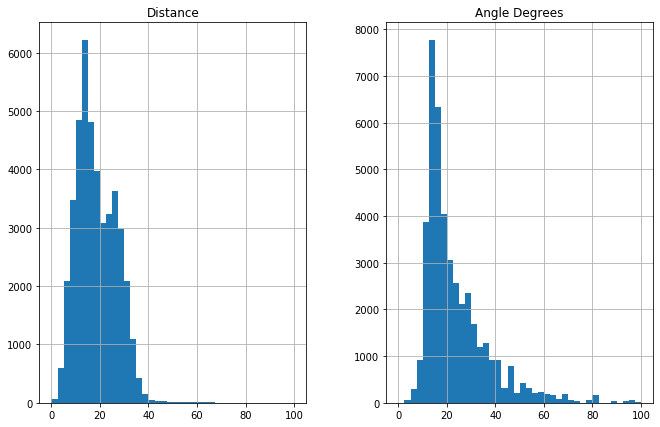

In [20]:
# Check how shots are distributed by angle and distance

fig , axes = plt.subplots(1 ,2 , figsize = (11,7))
distance = data_1.hist("Distance", bins = 40 , range = (0, 100), ax = axes[0])
angles = data_1.hist("Angle Degrees", bins = 40, range = (0, 100), ax = axes[1])

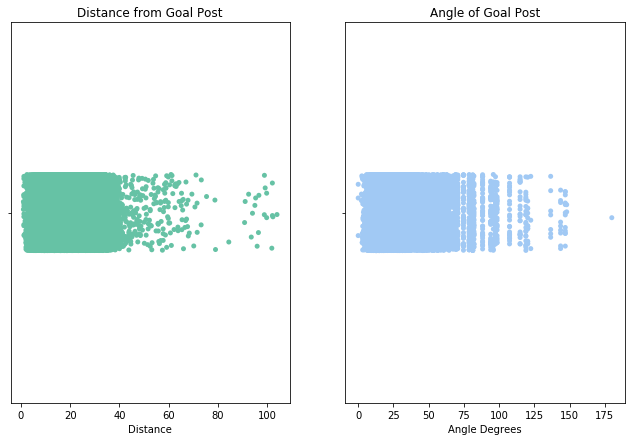

In [21]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))
distance = sns.stripplot(x = data_1["Distance"],  ax = axes[0], palette = "Set2")
distance.set(title = "Distance from Goal Post")

angle = sns.stripplot(x = data_1["Angle Degrees"], ax = axes[1], palette = "pastel")
angle.set(title = "Angle of Goal Post")

plt.show()

### - Most shots are taken between 10 and 20 metres from the goal
### - Shots closer to the goal (with a wide angle) are harder to produce

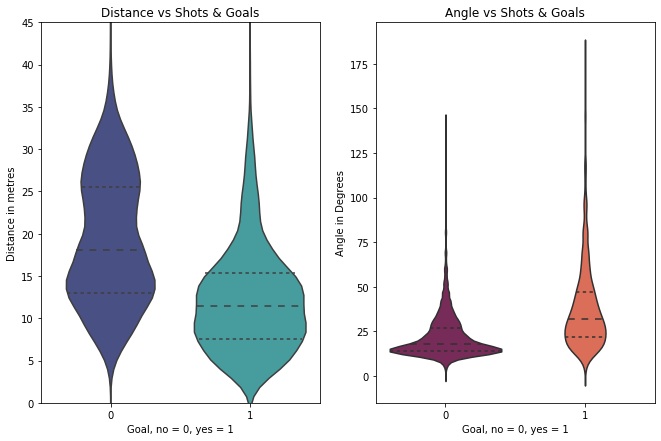

In [22]:
# Investigation of shots and goals using distance and angle.
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.violinplot(x = "Goal", y = "Distance", data = data_1, inner = "quart", palette = "mako", ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle2 = sns.violinplot(x = "Goal", y = "Angle Degrees", data = data_1, inner = "quart", palette = "rocket", ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

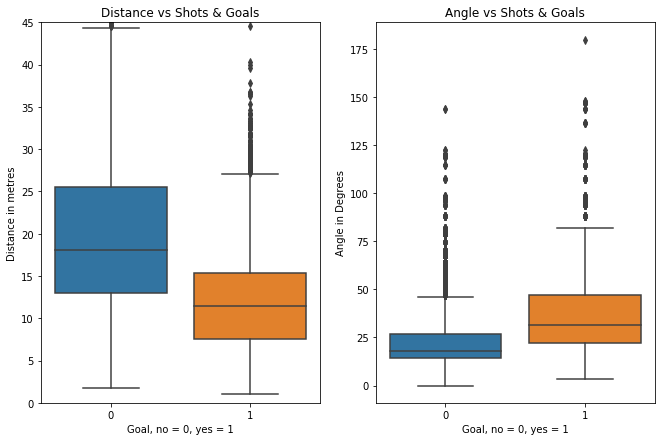

In [23]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance3 = sns.boxplot(x = "Goal", y = "Distance", data = data_1,  ax = axes[0])
distance3.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle3 = sns.boxplot(x = "Goal", y = "Angle Degrees", data = data_1,  ax = axes[1])
angle3.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

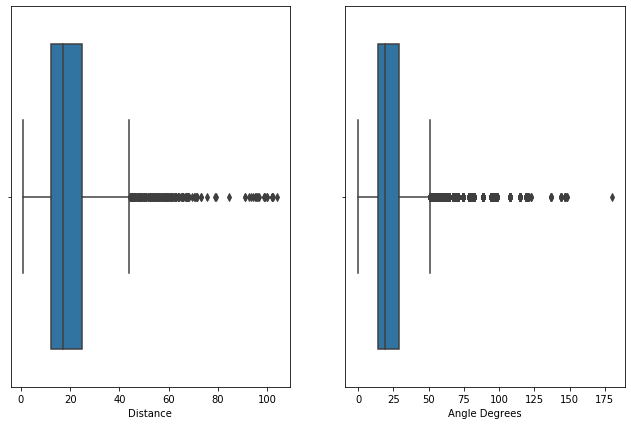

In [24]:
fig , axes = plt.subplots(1 ,2 ,figsize = (11,7))
sns.boxplot(x = data_1['Distance'] ,ax = axes[0])
sns.boxplot(x = data_1['Angle Degrees'] ,ax = axes[1])

### - From the violin plots we can conclude that shots that result into goals are taken closer to the goal post
### - Goals are scored from angles between 20 degrees and 50 degrees

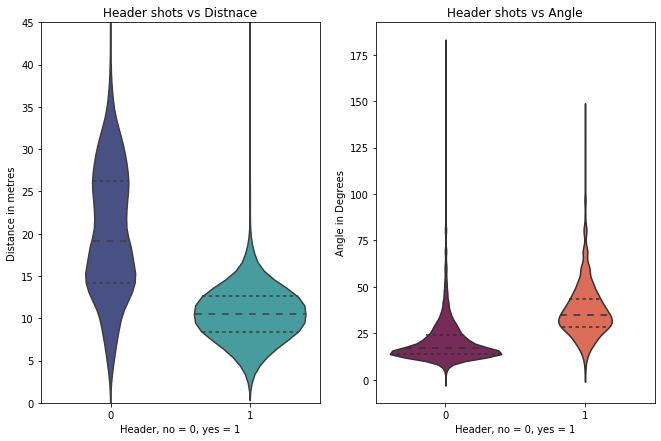

In [25]:
# Comparison of shots , goals , angle , distance and body part.

#1. Header
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.violinplot(x = "header", y = "Distance", data = data_1, inner = "quart", palette = "mako", ax = axes[0])
distance2.set(xlabel = "Header, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Header shots vs Distnace" , ylim = (0,45))

angle2 = sns.violinplot(x = "header", y = "Angle Degrees", data = data_1, inner = "quart", palette = "rocket", ax = axes[1])
angle2.set(xlabel = "Header, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Header shots vs Angle")

plt.show()

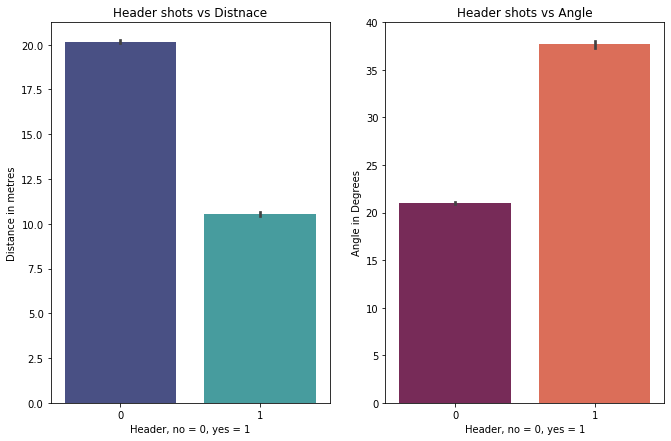

In [26]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.barplot(x = "header", y = "Distance", data = data_1,  palette = "mako", ax = axes[0])
distance2.set(xlabel = "Header, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Header shots vs Distnace" )
angle2 = sns.barplot(x = "header", y = "Angle Degrees", data = data_1, palette = "rocket", ax = axes[1])
angle2.set(xlabel = "Header, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Header shots vs Angle", ylim =(0,40))

plt.show()

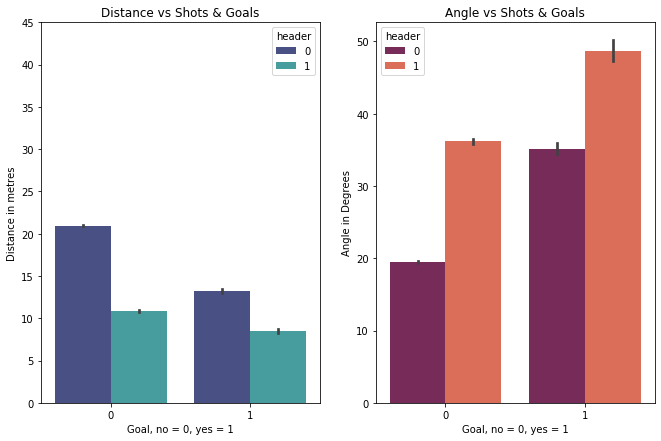

In [27]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.barplot(x = "Goal", y = "Distance", data = data_1, palette = "mako", hue = "header", ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle2 = sns.barplot(x = "Goal", y = "Angle Degrees", data = data_1,  palette = "rocket", hue = "header" , ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

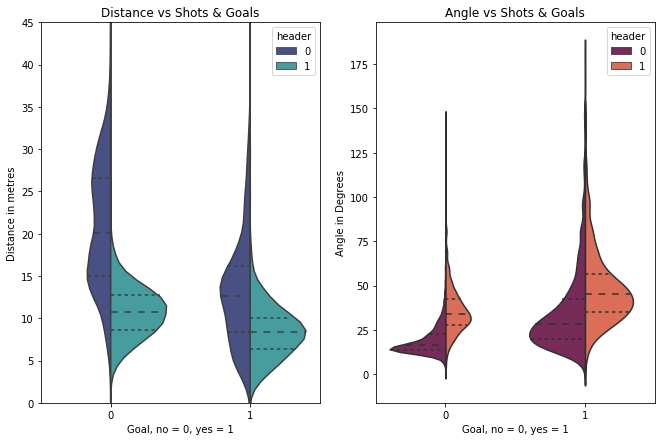

In [28]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.violinplot(x = "Goal", y = "Distance", data = data_1, inner = "quart", palette = "mako", hue = "header", split = True, ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle2 = sns.violinplot(x = "Goal", y = "Angle Degrees", data = data_1, inner = "quart", palette = "rocket",hue = "header", split = True, ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

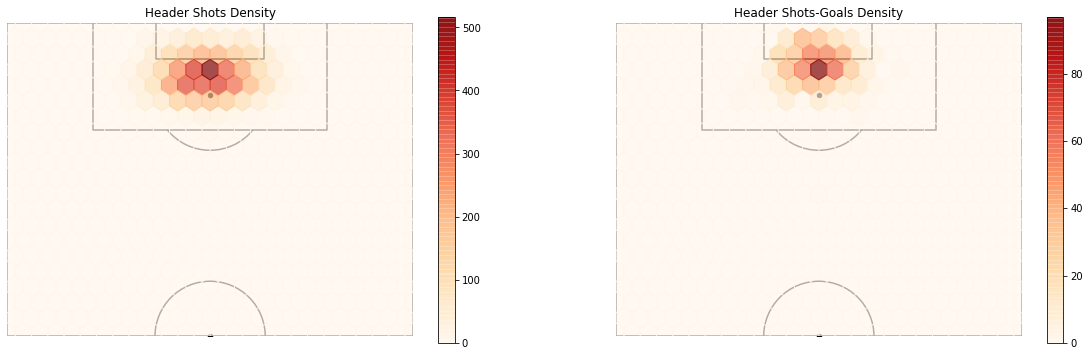

In [29]:
fig, ax = plt.subplots(1, 2 ,figsize = (20, 6))

plt.sca(ax[0])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[0])

headers = data_1[data_1["header"]== 1]

plt.hexbin(data = headers, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[0].set_title("Header Shots Density")

plt.sca(ax[1])
header_goals = data_1[(data_1['header']== 1) & (data_1["Goal"] == 1)]

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[1])

plt.hexbin(data = header_goals, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[1].set_title("Header Shots-Goals Density")

plt.show()


### - The plots show that most header shots are taken between 10m to 15m.
### - Header shots are taken between 30 to 50 degrees

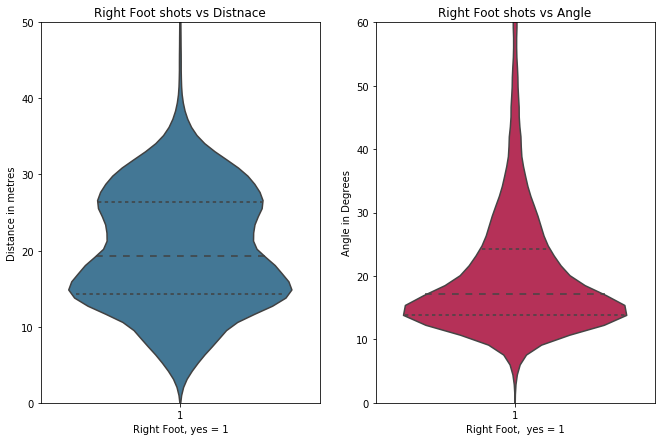

In [30]:
# 2. Right Foot

fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

data_r = data_1[data_1['Right Foot'] == 1]

distance2 = sns.violinplot(x = "Right Foot", y = "Distance", data = data_r, inner = "quart", palette = "mako", ax = axes[0])
distance2.set(xlabel = "Right Foot, yes = 1" , ylabel = "Distance in metres", title = "Right Foot shots vs Distnace" , ylim = (0,50))

angle2 = sns.violinplot(x = "Right Foot", y = "Angle Degrees", data = data_r, inner = "quart", palette = "rocket", ax = axes[1])
angle2.set(xlabel = "Right Foot,  yes = 1" , ylabel = "Angle in Degrees", title = "Right Foot shots vs Angle" , ylim = (0,60))

plt.show()

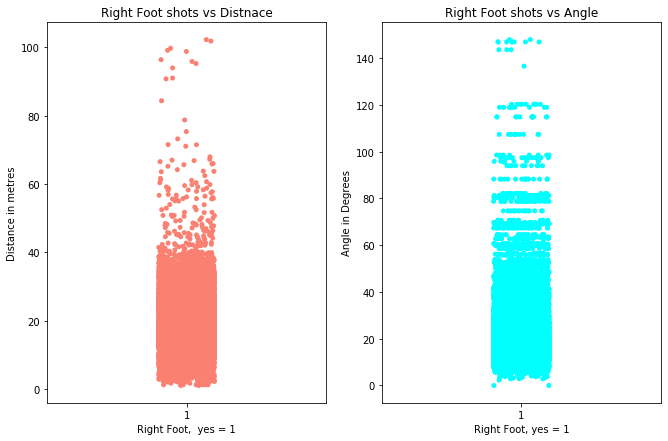

In [31]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.stripplot(x = "Right Foot", y = "Distance", data = data_r, color = "salmon", ax = axes[0])
distance2.set(xlabel = "Right Foot,  yes = 1" , ylabel = "Distance in metres", title = "Right Foot shots vs Distnace" )
angle2 = sns.stripplot(x = "Right Foot", y = "Angle Degrees", data = data_r, color = "cyan", ax = axes[1])
angle2.set(xlabel = "Right Foot, yes = 1" , ylabel = "Angle in Degrees", title = "Right Foot shots vs Angle")

plt.show()

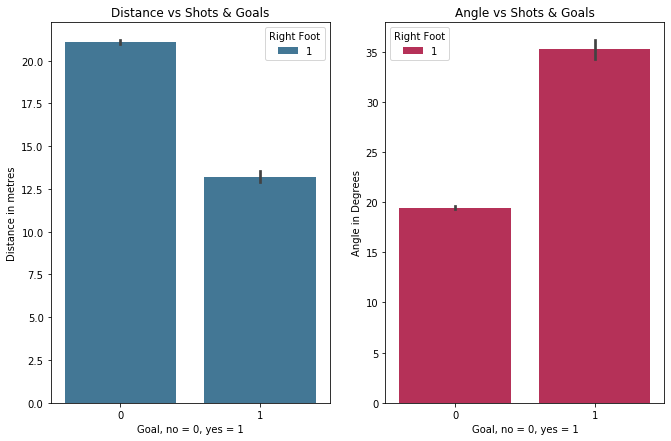

In [32]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.barplot(x = "Goal", y = "Distance", data = data_r, palette = "mako", hue = "Right Foot", ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" )

angle2 = sns.barplot(x = "Goal", y = "Angle Degrees", data = data_r,  palette = "rocket", hue = "Right Foot" , ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

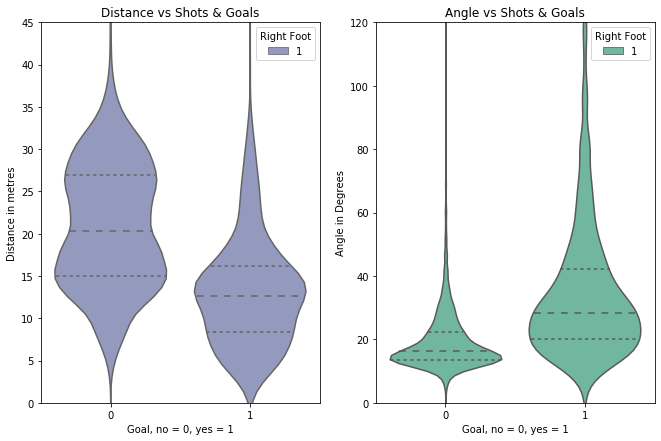

In [33]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.violinplot(x = "Goal", y = "Distance", data = data_r, inner = "quart", palette = "BuPu", hue = "Right Foot",  ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle2 = sns.violinplot(x = "Goal", y = "Angle Degrees", data = data_r, inner = "quart", palette = "BuGn",hue = "Right Foot",  ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals", ylim = (0,120))

plt.show()

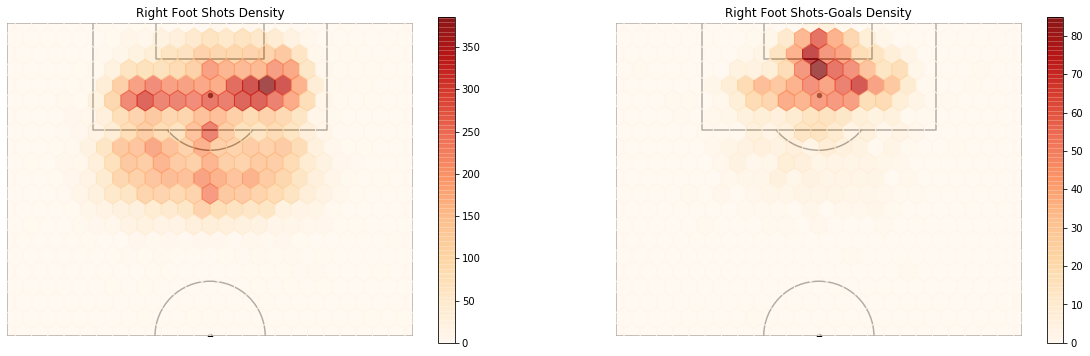

In [34]:
fig, ax = plt.subplots(1, 2 ,figsize = (20, 6))

plt.sca(ax[0])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[0])

plt.hexbin(data = data_r, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[0].set_title("Right Foot Shots Density")

plt.sca(ax[1])
rf_goals = data_1[(data_1['Right Foot']== 1) & (data_1["Goal"] == 1)]

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[1])

plt.hexbin(data = rf_goals, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[1].set_title("Right Foot Shots-Goals Density")

plt.show()


### - Most Right Foot shots are taken around 20m to the goal.
### - The angle for most Right Foot shots is around 20 degrees.
### - Goals scored from right foot shots are scored around 12.5 m to the goal post and around 35 degrees.

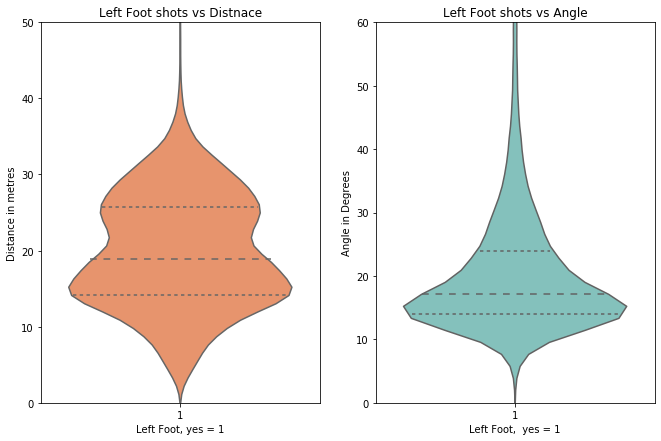

In [35]:
# 3. Left Foot
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

data_l = data_1[data_1['Left Foot'] == 1]

distance2 = sns.violinplot(x = "Left Foot", y = "Distance", data = data_l, inner = "quart", palette = "OrRd", ax = axes[0])
distance2.set(xlabel = "Left Foot, yes = 1" , ylabel = "Distance in metres", title = "Left Foot shots vs Distnace" , ylim = (0,50))

angle2 = sns.violinplot(x = "Left Foot", y = "Angle Degrees", data = data_l, inner = "quart", palette = "GnBu", ax = axes[1])
angle2.set(xlabel = "Left Foot,  yes = 1" , ylabel = "Angle in Degrees", title = "Left Foot shots vs Angle" , ylim = (0,60))

plt.show()

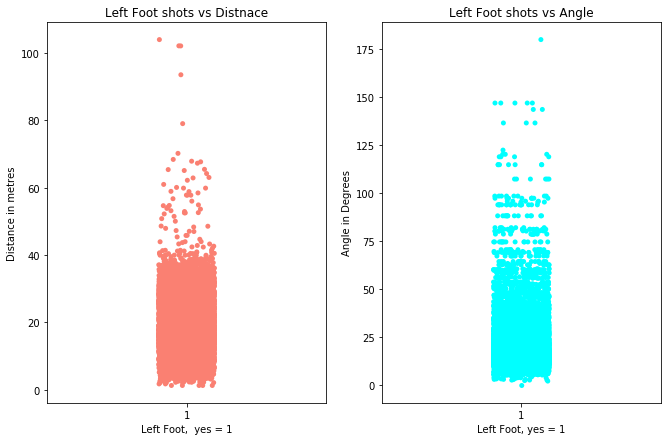

In [36]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.stripplot(x = "Left Foot", y = "Distance", data = data_l, color = "salmon", ax = axes[0])
distance2.set(xlabel = "Left Foot,  yes = 1" , ylabel = "Distance in metres", title = "Left Foot shots vs Distnace" )

angle2 = sns.stripplot(x = "Left Foot", y = "Angle Degrees", data = data_l, color = "cyan", ax = axes[1])
angle2.set(xlabel = "Left Foot, yes = 1" , ylabel = "Angle in Degrees", title = "Left Foot shots vs Angle")

plt.show()

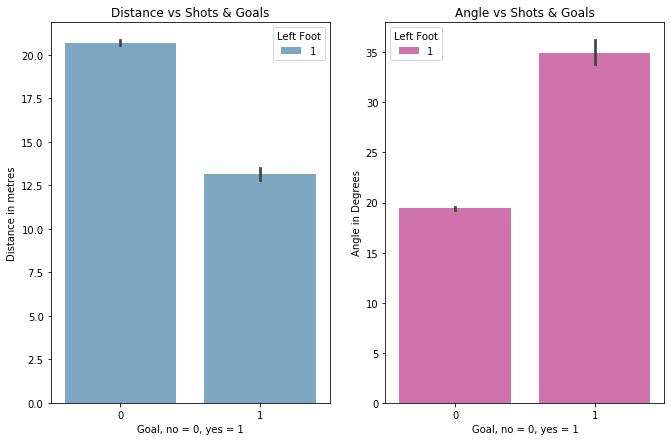

In [37]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.barplot(x = "Goal", y = "Distance", data = data_l, palette = "PuBu", hue = "Left Foot", ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" )

angle2 = sns.barplot(x = "Goal", y = "Angle Degrees", data = data_l,  palette = "PuRd", hue = "Left Foot" , ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals")

plt.show()

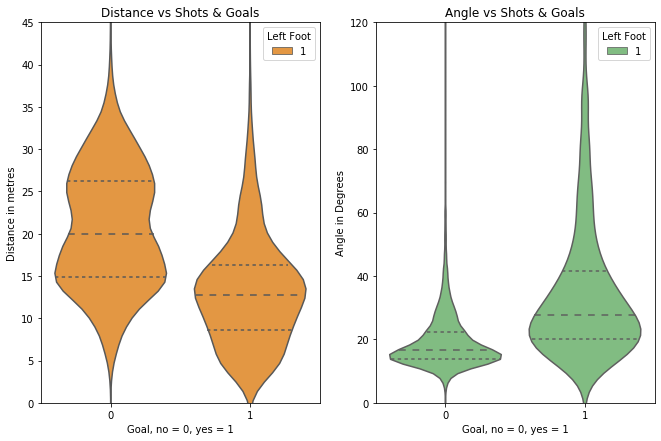

In [38]:
fig , axes = plt.subplots(1 ,2 , figsize = (11,7))

distance2 = sns.violinplot(x = "Goal", y = "Distance", data = data_l, inner = "quart", palette = "YlOrBr", hue = "Left Foot",  ax = axes[0])
distance2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Distance in metres", title = "Distance vs Shots & Goals" , ylim = (0,45))

angle2 = sns.violinplot(x = "Goal", y = "Angle Degrees", data = data_l, inner = "quart", palette = "YlGn",hue = "Left Foot",  ax = axes[1])
angle2.set(xlabel = "Goal, no = 0, yes = 1" , ylabel = "Angle in Degrees", title = "Angle vs Shots & Goals", ylim = (0,120))

plt.show()

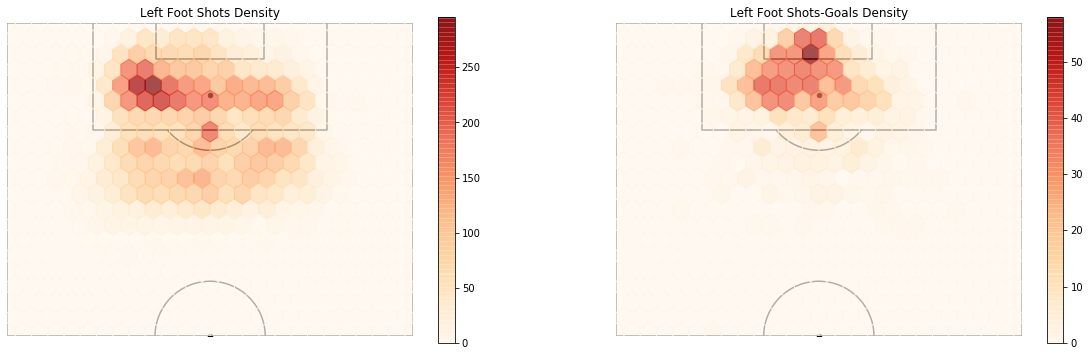

In [39]:
fig, ax = plt.subplots(1, 2 ,figsize = (20, 6))

plt.sca(ax[0])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[0])

plt.hexbin(data = data_l, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[0].set_title("Left Foot Shots Density")

plt.sca(ax[1])
lf_goals = data_1[(data_1['Left Foot']== 1) & (data_1["Goal"] == 1)]

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[1])

plt.hexbin(data = lf_goals, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[1].set_title("Left Foot Shots-Goals Density")

plt.show()


### - Similar to Right Foot shots, Left Foot shots are taken around 20m to the goal post and at an angle of around 20 degrees
### - Goals scored from left foot shots are scored around 12.5m and at an angle of 35 degrees
### - Right Foot and Left Foot shots have similar outcomes and metrices

In [40]:
right_foot = data_r['Right Foot'].count()
print("Right Foot Shots:" , right_foot)

left_foot = data_l['Left Foot'].count()
print("Left Foot Shots:", left_foot)

header_shots = headers['header'].count()
print("Header shots:", header_shots)

Right Foot Shots: 21939
Left Foot Shots: 14123
Header shots: 6981


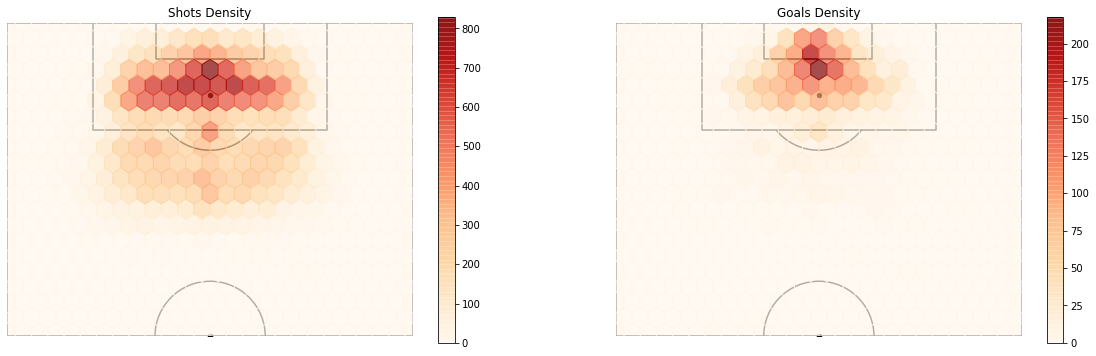

In [41]:
# Plotting the number of shots from different points vs the number of goals from different points
fig, ax = plt.subplots(1, 2 ,figsize = (20, 6))

plt.sca(ax[0])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[0])

#shots = data_1[data_1["header"]== 0]

plt.hexbin(data = data_1, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[0].set_title("Shots Density")

plt.sca(ax[1])
goals = data_1[data_1["Goal"] == 1]

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[1])

plt.hexbin(data = goals, x = 'Y' , y = 'X', zorder = 1, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[1].set_title("Goals Density")

plt.show()


### - The density plots show where shots are mostly taken putting into consideration distance and angle.
### - Majority of the shots are taken from the penalty spot
### - Majority the goals are scored from the same area with a very close proximity to the goal post

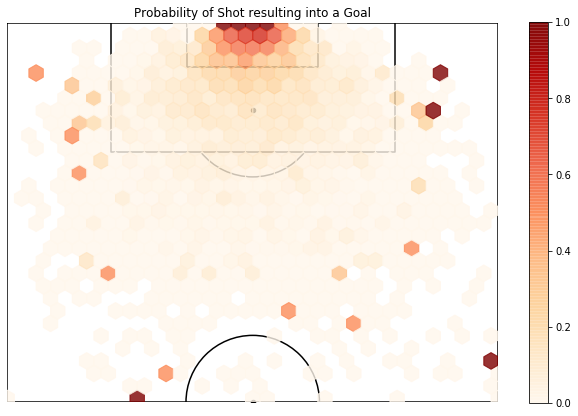

In [42]:
# Plotting a probability density to assess which areas of the pitch have a high probability of a shot resulting into a goal

prob = np.array(data_1['Goal'])

fig, ax = plt.subplots(figsize = (11,7))

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax)

plt.hexbin(data = data_1, x = 'Y', y = 'X', C = prob, reduce_C_function = np.mean, cmap = "OrRd", gridsize = (34, 15), alpha = .8, extent = (0, 68, 0, 52))

ax.set_xlim(0, 68)
ax.set_ylim(52.5, 0)
plt.colorbar()
plt.axis("off")
ax.set_title("Probability of Shot resulting into a Goal")

plt.show()

### - The closer you shoot from the goal, the more likely you are to score
### - Some outliers are seen, showing that the few shots taken from those areas resulted into goals

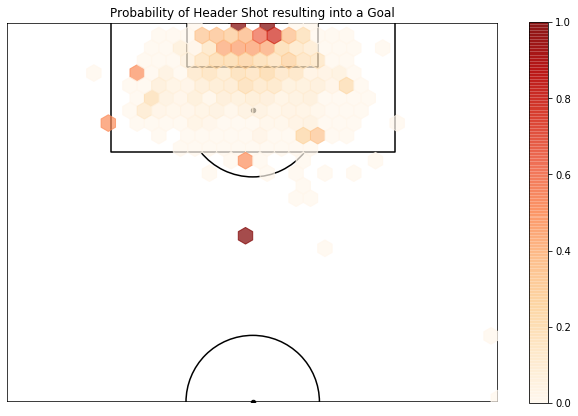

In [43]:
# Probability of headers resulting into goals.
prob_header = data_1[data_1['header']== 1]

prob = np.array(prob_header['Goal'])

fig, ax = plt.subplots(figsize = (11, 7))

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax)

plt.hexbin(data = prob_header, x = 'Y', y = 'X', C = prob, reduce_C_function = np.mean, cmap = 'OrRd', gridsize = (34,15), alpha = .7, extent = (0, 68, 0, 52))

ax.set_xlim(0, 68)
ax.set_ylim(52.5, 0)
plt.colorbar()
plt.axis("off")
ax.set_title("Probability of Header Shot resulting into a Goal")

plt.show()

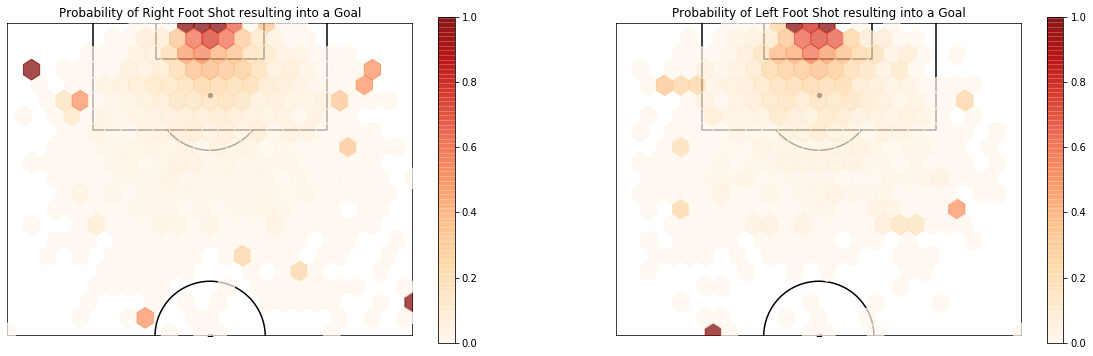

In [44]:
# Probability of left foot/right foot shots resulting into shots.

fig, ax = plt.subplots(1, 2 ,figsize = (20, 6))

plt.sca(ax[0])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[0])

prob_r = data_1[data_1['Right Foot']== 1]

prob = np.array(prob_r['Goal'])

plt.hexbin(data = prob_r, x = 'Y' , y = 'X', C = prob, reduce_C_function = np.mean, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[0].set_xlim(0, 68)
ax[0].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[0].set_title("Probability of Right Foot Shot resulting into a Goal")

plt.sca(ax[1])
draw_pitch(orientation = "vertical", aspect = "half", pitch_color = "white", line_color = "black", ax = ax[1])

prob_l = data_1[data_1['Left Foot']== 1]

prob = np.array(prob_l['Goal'])

plt.hexbin(data = prob_l, x = 'Y' , y = 'X', C = prob, reduce_C_function = np.mean, cmap = 'OrRd', gridsize = (25,10), alpha = .7, extent = (0, 68, 0, 52))
ax[1].set_xlim(0, 68)
ax[1].set_ylim(52.5, 0)

plt.colorbar()
plt.axis("off")

ax[1].set_title("Probability of Left Foot Shot resulting into a Goal")

plt.show()


### - Header shots exhibit the same trend as regular shots but their probability to result into goals is less. This may be because they are harder to produce while closer to the goal
### - In conclusion, for all shots ie right foot, left foot and headers, the closer you are to the goal the more likely you are to score a goal

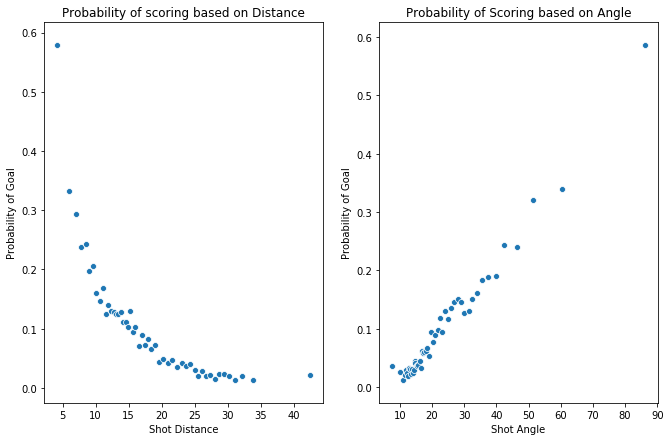

In [45]:
# Assessing the probability of a goal being scored in comparison to distance and angle.

fig, axes = plt.subplots(1, 2, figsize = (11, 7))

data_1['Goal'] = data_1['Goal'].astype(int)

data_1['Distance Bins'] = pd.qcut(data_1['Distance'], q = 50)

dist_prob = data_1.groupby('Distance Bins', as_index = False)['Goal'].mean()['Goal']
dist_mean = data_1.groupby('Distance Bins', as_index = False)['Distance'].mean()['Distance']
dist_trend = sns.scatterplot(x = dist_mean, y = dist_prob, ax = axes[0])
dist_trend.set(xlabel = 'Shot Distance', ylabel = 'Probability of Goal', title = 'Probability of scoring based on Distance')

data_1['Angle Bins'] = pd.qcut(data_1['Angle Degrees'], q = 50)

angle_prob = data_1.groupby('Angle Bins', as_index = False)['Goal'].mean()['Goal']
angle_mean = data_1.groupby('Angle Bins', as_index = False)['Angle Degrees'].mean()['Angle Degrees']
angle_trend = sns.scatterplot(x = angle_mean, y = angle_prob, ax = axes[1])
angle_trend.set(xlabel = 'Shot Angle', ylabel = 'Probability of Goal', title = 'Probability of Scoring based on Angle')

plt.show()

### - We can conclude that the further you are from the goal post the harder it is for a shot to result into a goal.
### - The less of the goal you can see, the lower the chances of a shot resulting into a goal

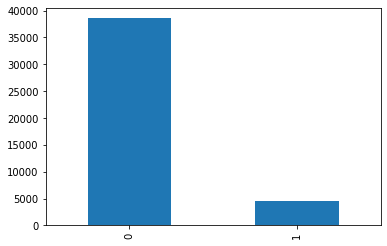

In [46]:
data_1['Goal'].value_counts().plot.bar()

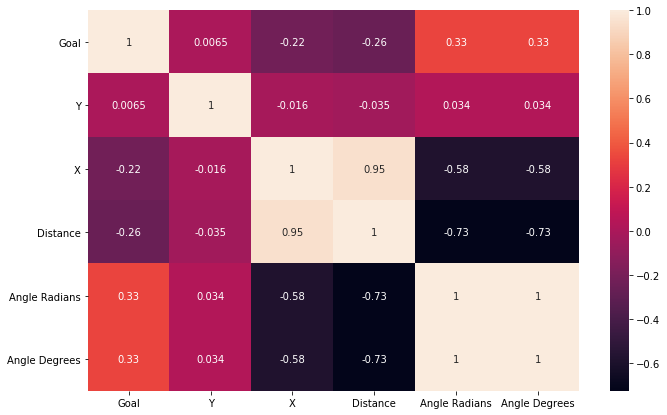

In [47]:
matrix = data_1.corr()

fig, ax = plt.subplots(figsize = (11,7))
sns.heatmap(matrix, xticklabels = matrix.columns, yticklabels = matrix.columns, annot = True , ax = ax)

In [48]:
# Creating the xG model

train_distance = data_1[['Goal', 'Distance']].copy()
train_distance['Goal'] = pd.to_numeric(train_distance['Goal'])

y_dist = train_distance['Goal']
X_dist = train_distance.drop('Goal', axis = 1)

X_train_distance, X_test_distance , y_train_distance, y_test_distance = train_test_split(X_dist, y_dist, train_size = 0.80, random_state = 10)

log_d = LogisticRegression()
log_d.fit(X_train_distance, y_train_distance)

y_pred_dist = log_d.predict(X_test_distance)

print(classification_report(y_test_distance, y_pred_dist))

print(confusion_matrix(y_test_distance, y_pred_dist))


              precision    recall  f1-score   support

           0       0.90      1.00      0.95      7757
           1       0.00      0.00      0.00       852

    accuracy                           0.90      8609
   macro avg       0.45      0.50      0.47      8609
weighted avg       0.81      0.90      0.85      8609

[[7757    0]
 [ 852    0]]


C:\Users\Njula Chakaya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Njula Chakaya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Njula Chakaya\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [49]:
train_angle = data_1[['Goal', 'Angle Degrees']].copy()
train_angle['Goal'] = pd.to_numeric(train_angle['Goal'])

y_ang = train_angle['Goal']
X_ang = train_angle.drop('Goal', axis = 1)

X_train_angle , X_test_angle, y_train_angle, y_test_angle = train_test_split(X_ang, y_ang, train_size = 0.80, random_state = 10)

log_a = LogisticRegression()
log_a.fit(X_train_angle, y_train_angle)

y_pred_ang = log_a.predict(X_test_angle)

print(classification_report(y_test_angle, y_pred_ang))

print(confusion_matrix(y_test_angle, y_pred_ang))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7757
           1       0.61      0.11      0.19       852

    accuracy                           0.90      8609
   macro avg       0.76      0.55      0.57      8609
weighted avg       0.88      0.90      0.87      8609

[[7696   61]
 [ 757   95]]


In [50]:
train_both = data_1[['Goal', 'Distance', 'Angle Degrees']].copy()
train_both['Goal'] = pd.to_numeric(train_both['Goal'])

y_b = train_both['Goal']
X_b = train_both.drop('Goal', axis = 1)

X_train_both, X_test_both, y_train_both, y_test_both = train_test_split(X_b, y_b, train_size = 0.80, random_state = 10)

log_b = LogisticRegression()
log_b.fit(X_train_both, y_train_both)

y_pred_b = log_b.predict(X_test_both)

print(classification_report(y_test_both, y_pred_b))

print(confusion_matrix(y_test_both, y_pred_b))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      7757
           1       0.67      0.08      0.15       852

    accuracy                           0.91      8609
   macro avg       0.79      0.54      0.55      8609
weighted avg       0.88      0.91      0.87      8609

[[7722   35]
 [ 781   71]]


ROC_AUC Score: 0.7650190710677195


Text(0.5, 1.0, 'ROC Graph')

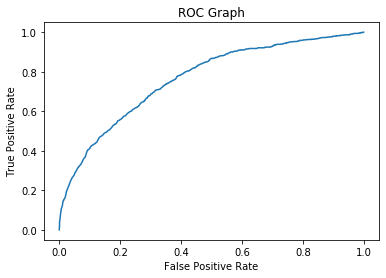

In [51]:
y_score_both = log_b.fit(X_train_both, y_train_both).decision_function(X_test_both)

fpr2, tpr2, _ = roc_curve(y_test_both, y_score_both)

print("ROC_AUC Score:", roc_auc_score(y_test_both, y_score_both))

plt.plot(fpr2, tpr2, label = 'ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')

In [68]:
train = data_1[['Goal', 'Distance', 'Angle Degrees', 'Y']].copy()
train['Goal'] = pd.to_numeric(train['Goal'])

y = train['Goal']
X = train.drop('Goal', axis = 1)

#X = StandardScaler().fit_transform(X)

X_train, X_test, y_train , y_test = train_test_split(X, y , train_size = 0.70, random_state = 0)

smote = SMOTE(random_state = 101)

X_oversampled , y_oversampled = smote.fit_resample(X_train, y_train)

classifier = LogisticRegression(C=1000.0, random_state=0)
classifier.fit(X_oversampled, y_oversampled)

print(classification_report(y_test, classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.69      0.80     11608
           1       0.20      0.68      0.31      1305

    accuracy                           0.69     12913
   macro avg       0.57      0.68      0.55     12913
weighted avg       0.87      0.69      0.75     12913



ROC_AUC Score: 0.7600520581657253


Text(0.5, 1.0, 'ROC Graph')

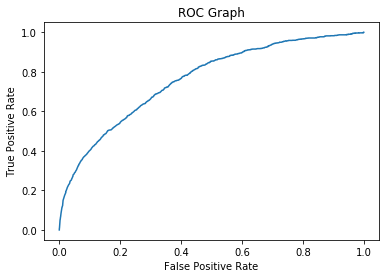

In [55]:
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)

print("ROC_AUC Score:", roc_auc_score(y_test, y_score))

plt.plot(fpr,tpr,label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Graph')

(27, 0)

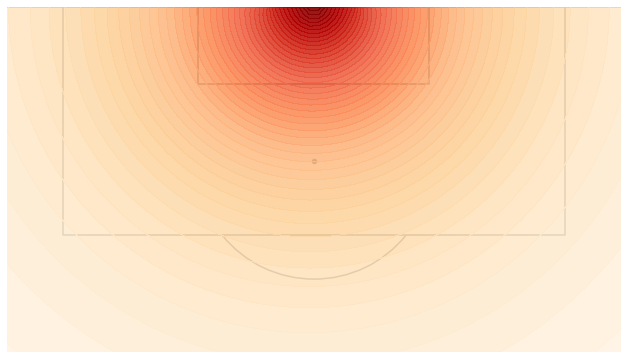

In [56]:
def Logistic(Y):
    g_y = 1 + np.exp(-Y)
    return np.reciprocal(g_y)

x0 = np.linspace(-34, 34, 100)
x1 = np.linspace(.1, 53 , 100)
x_0 = np.linspace(0, 68, 100)
x0_grid, x1_grid = np.meshgrid(x0, x1)
c=7.32

a=np.sqrt((x0_grid-7.32/2)**2 + x1_grid**2)
b=np.sqrt((x0_grid+7.32/2)**2 + x1_grid**2)
ang = np.arccos((c**2-a**2-b**2)/(-2*a*b))
dis = np.sqrt((x1_grid)**2+(x0_grid)**2)

h_grid_Y = Logistic(classifier.coef_[0][0]*dis +classifier.coef_[0][1]*ang +classifier.coef_[0][2]*(x0_grid) +classifier.intercept_[0])

fig, ax = plt.subplots(figsize=(11, 7))

draw_pitch(orientation = "vertical", aspect = "half", pitch_color = 'white', line_color = "black", ax = ax)

CS =plt.contourf(x_0,x1,  h_grid_Y, alpha = .9, cmap = 'OrRd', levels = 50)

plt.axis('off')

ax.set_xlim(10,58)
ax.set_ylim(27,0)

(22, 0)

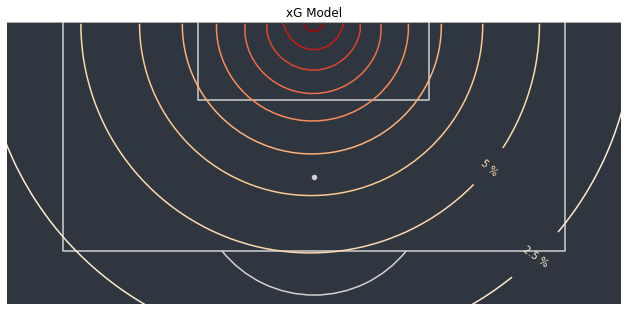

In [57]:
matplotlib.rcParams['xtick.direction'] = 'out'
matplotlib.rcParams['ytick.direction'] = 'out'

fig, ax = plt.subplots(figsize=(11, 7))
draw_pitch(orientation="vertical",
           aspect="half",
           pitch_color='#303640',
           line_color="lightgrey",
           ax=ax)



CS =plt.contour(x_0,x1, h_grid_Y,alpha=1,cmap='OrRd',levels=10)

# Define a class that forces representation of float to look a certain way
# This remove trailing zero so '1.0' becomes '1'
class nf(float):
    def __repr__(self):
        str = '%.1f' % (self.__float__(),)
        if str[-1] == '0':
            return '%.0f' % self.__float__()
        else:
            return '%.1f' % self.__float__()


# Recast levels to new class
CS.levels = [nf(val*100) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r \%%'
else:
    fmt = '%r %%'
plt.clabel(CS, CS.levels[:3],inline=True, fmt=fmt, fontsize=10)

plt.title('xG Model')

plt.axis('off')
ax.set_xlim(10,58)
ax.set_ylim(22,0)

In [58]:
bsmote = BorderlineSMOTE(random_state = 101, kind = 'borderline-1')

X_oversample_borderline, y_oversample_borderline = bsmote.fit_resample(X_train, y_train)

classifier_border = LogisticRegression()
classifier_border.fit(X_oversample_borderline, y_oversample_borderline)

print(classification_report(y_test, classifier_border.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.66      0.78     11608
           1       0.19      0.71      0.30      1305

    accuracy                           0.66     12913
   macro avg       0.57      0.68      0.54     12913
weighted avg       0.88      0.66      0.73     12913



In [59]:
train = data_1[['Goal', 'Distance', 'Angle Degrees', 'Right Foot', 'Left Foot', 'header']].copy()
train['Goal'] = pd.to_numeric(train['Goal'])
train['Goal'] = pd.to_numeric(train['Right Foot'])
train['Goal'] = pd.to_numeric(train['Left Foot'])
train['Goal'] = pd.to_numeric(train['header'])


y = train['Goal']
X = train.drop('Goal', axis = 1)

X_train, X_test, y_train , y_test = train_test_split(X, y , train_size = 0.70, random_state = 0)

smote = SMOTE(random_state = 101)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

X_oversampled , y_oversampled = smote.fit_resample(X_train_std, y_train)

classifier = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=750)
classifier.fit(X_oversampled, y_oversampled)

print(classification_report(y_test, classifier.predict(X_test_std)))

print(confusion_matrix(y_test, classifier.predict(X_test_std)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10855
           1       1.00      1.00      1.00      2058

    accuracy                           1.00     12913
   macro avg       1.00      1.00      1.00     12913
weighted avg       1.00      1.00      1.00     12913

[[10855     0]
 [    0  2058]]


In [60]:
train = data_1[['Goal', 'Distance', 'Angle Degrees', 'Right Foot', 'Left Foot', 'header']].copy()
train['Goal'] = pd.to_numeric(train['Goal'])
train['Goal'] = pd.to_numeric(train['Right Foot'])
train['Goal'] = pd.to_numeric(train['Left Foot'])
train['Goal'] = pd.to_numeric(train['header'])

y = train['Goal']
X = train.drop('Goal', axis = 1)

X_train, X_test, y_train , y_test = train_test_split(X, y , train_size = 0.80, random_state = 101)

smote = SMOTE(random_state = 101)

X_oversampled , y_oversampled = smote.fit_resample(X_train, y_train)

dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_oversampled, y_oversampled)

print(classification_report(y_test, dt_classifier.predict(X_test)))

print(confusion_matrix(y_test, dt_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7211
           1       1.00      1.00      1.00      1398

    accuracy                           1.00      8609
   macro avg       1.00      1.00      1.00      8609
weighted avg       1.00      1.00      1.00      8609

[[7211    0]
 [   0 1398]]


In [61]:
train = data_1[['Goal', 'Distance', 'Angle Degrees', 'Right Foot', 'Left Foot', 'header']].copy()
train['Goal'] = pd.to_numeric(train['Goal'])
train['Goal'] = pd.to_numeric(train['Right Foot'])
train['Goal'] = pd.to_numeric(train['Left Foot'])
train['Goal'] = pd.to_numeric(train['header'])


y = train['Goal']
X = train.drop('Goal', axis = 1)

X_train, X_test, y_train , y_test = train_test_split(X, y , train_size = 0.80, random_state = 101)

smote = SMOTE(random_state = 101)

X_oversampled , y_oversampled = smote.fit_resample(X_train, y_train)

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_oversampled, y_oversampled)

print(classification_report(y_test, rf_classifier.predict(X_test)))

print(confusion_matrix(y_test, rf_classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7211
           1       1.00      1.00      1.00      1398

    accuracy                           1.00      8609
   macro avg       1.00      1.00      1.00      8609
weighted avg       1.00      1.00      1.00      8609

[[7211    0]
 [   0 1398]]


In [62]:
data_1.head()

,Goal,playerid,teamid,matchid,header,Right Foot,Left Foot,Y,X,Distance,Angle Radians,Angle Degrees,Distance Bins,Angle Bins
46,1,25413,1609,2499719,0,1,0,27.88,12.60,14.007655,0.467241,26.770923,"(13.905, 14.29]","(26.422, 27.483]"
62,0,26150,1631,2499719,0,0,1,35.36,15.75,15.808608,0.453557,25.986925,"(15.409, 15.809]","(25.524, 26.422]"
91,1,14763,1631,2499719,1,0,0,35.36,4.20,4.414703,1.375115,78.788301,"(1.0490000000000002, 5.294]","(67.375, 180.0]"
128,0,7868,1609,2499719,0,0,1,22.44,19.95,23.057235,0.274666,15.737204,"(22.558, 23.285]","(15.601, 15.9]"
249,0,7868,1609,2499719,0,1,0,20.40,26.25,29.563872,0.219665,12.585866,"(28.965, 29.682]","(12.518, 12.831]"


In [78]:
y_pred2 = classifier.predict_proba(X)
len(y_pred2)
data_1['xG'] = y_pred2

goal_Xg = data_1[['Goal', 'xG','Distance', 'Angle Degrees','header', 'Right Foot', 'Left Foot','playerid','teamid']]
goal_Xg.sample(10)

,Goal,xG,Distance,Angle Degrees,header,Right Foot,Left Foot,playerid,teamid
262418,1,0.580708,16.647354,19.275224,0,1,0,3484,3162
510949,0,0.459841,13.918366,28.990776,0,1,0,625,3172
610683,0,0.618454,15.538391,7.678032,0,1,0,11669,1659
85427,0,0.759237,24.294907,15.632010,0,0,1,285457,3782
424555,0,0.704989,20.552433,11.679144,0,0,1,15014,2454
622982,0,0.621962,19.009776,21.681737,0,1,0,625,3172
454261,0,0.370247,11.550000,35.165059,1,0,0,8717,1624
495692,0,0.563729,16.211107,20.294849,0,1,0,4792,3162
384678,0,0.611183,17.330000,16.417812,0,1,0,14836,701
151411,0,0.437053,10.871656,20.138387,1,0,0,280419,3172


In [79]:
goal_Xg.to_csv('xG values.csv')